Step 1: Install & Imports

In [1]:
# !pip install torchvision matplotlib

import os
import cv2
import json
import torch
import torchvision
import numpy as np
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.ssd import SSD300_VGG16_Weights
from torchvision.transforms import v2
import matplotlib.pyplot as plt


Step 2: Prepare COCO Subset Dataset (Image + Annotations)

In [2]:
class SSDDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(ann_file, 'r') as f:
            coco = json.load(f)

        self.images = coco['images']
        self.annotations = coco['annotations']
        self.categories = coco['categories']
        self.img_id_to_ann = {}
        for ann in self.annotations:
            self.img_id_to_ann.setdefault(ann['image_id'], []).append(ann)

        self.cat_id_to_index = {cat['id']: idx for idx, cat in enumerate(self.categories)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        for ann in self.img_id_to_ann.get(img_info['id'], []):
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_index[ann['category_id']])

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)  # <- fix here

        return image, target



Step 3: Load Data

In [3]:
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision import transforms


train_dir = r"C:/Users/admin/Downloads/Code/ObjectDetection/coco_subset/train2017"
val_dir = r"C:/Users/admin/Downloads/Code/ObjectDetection/coco_subset/val2017"
train_ann = r"C:/Users/admin/Downloads/Code/ObjectDetection/coco_subset/annotations/instances_train2017.json"
val_ann = r"C:/Users/admin/Downloads/Code/ObjectDetection/coco_subset/annotations/instances_val2017.json"

# Basic transforms compatible with older torchvision
ssd_transform = transforms.Compose([
    transforms.Resize((300, 300)),                     # Resize to SSD input size
    transforms.ToTensor(),                             # Convert to tensor
    transforms.ConvertImageDtype(torch.float32)        # Normalize to float32
])

# Dataset (same)
train_dataset = SSDDataset(train_dir, train_ann, transform=ssd_transform)
val_dataset = SSDDataset(val_dir, val_ann, transform=ssd_transform)

# DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

Step 4: Initialize SSD300 Model and Set Up Training

In [4]:
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection.ssd import SSD300_VGG16_Weights
import torch

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained SSD model
weights = SSD300_VGG16_Weights.DEFAULT
model = ssd300_vgg16(weights=weights)

# SSD300 feature map configuration
in_channels = [512, 1024, 512, 256, 256, 256]
num_anchors = [4, 6, 6, 6, 4, 4]
num_classes = len(train_dataset.cat_id_to_index) + 1  # +1 for background

# Replace classification head
model.head.classification_head = SSDClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
)

# Move model to device
model.to(device)
print(f" SSD300 model loaded with {num_classes} classes on {device}")


 SSD300 model loaded with 9 classes on cuda


Step 5: Train SSD300 for 30 Epochs

In [5]:
import torch.optim as optim

# Set model to train mode
model.train()

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Train for 30 epochs
num_epochs = 30
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    epoch_loss = 0.0

    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward and backward pass
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")



Epoch [1/30]


100%|██████████| 1250/1250 [02:12<00:00,  9.44it/s]


Epoch 1 Loss: 28981.8227

Epoch [2/30]


100%|██████████| 1250/1250 [02:25<00:00,  8.60it/s]


Epoch 2 Loss: 23753.9148

Epoch [3/30]


100%|██████████| 1250/1250 [02:25<00:00,  8.61it/s]


Epoch 3 Loss: 13651.7601

Epoch [4/30]


100%|██████████| 1250/1250 [02:24<00:00,  8.65it/s]


Epoch 4 Loss: 12221.2184

Epoch [5/30]


100%|██████████| 1250/1250 [02:25<00:00,  8.56it/s]


Epoch 5 Loss: 12499.1603

Epoch [6/30]


100%|██████████| 1250/1250 [02:24<00:00,  8.68it/s]


Epoch 6 Loss: 11856.8464

Epoch [7/30]


100%|██████████| 1250/1250 [02:24<00:00,  8.62it/s]


Epoch 7 Loss: 12072.2891

Epoch [8/30]


100%|██████████| 1250/1250 [02:23<00:00,  8.69it/s]


Epoch 8 Loss: 12110.9712

Epoch [9/30]


100%|██████████| 1250/1250 [02:24<00:00,  8.66it/s]


Epoch 9 Loss: 11712.0730

Epoch [10/30]


100%|██████████| 1250/1250 [02:26<00:00,  8.55it/s]


Epoch 10 Loss: 12134.0607

Epoch [11/30]


100%|██████████| 1250/1250 [02:23<00:00,  8.68it/s]


Epoch 11 Loss: 11750.5195

Epoch [12/30]


100%|██████████| 1250/1250 [02:08<00:00,  9.69it/s]


Epoch 12 Loss: 11651.1394

Epoch [13/30]


100%|██████████| 1250/1250 [01:16<00:00, 16.38it/s]


Epoch 13 Loss: 11368.5221

Epoch [14/30]


100%|██████████| 1250/1250 [01:15<00:00, 16.63it/s]


Epoch 14 Loss: 11636.8880

Epoch [15/30]


100%|██████████| 1250/1250 [01:16<00:00, 16.40it/s]


Epoch 15 Loss: 11572.0286

Epoch [16/30]


100%|██████████| 1250/1250 [01:29<00:00, 14.04it/s]


Epoch 16 Loss: 10990.6693

Epoch [17/30]


100%|██████████| 1250/1250 [02:01<00:00, 10.27it/s]


Epoch 17 Loss: 11280.7089

Epoch [18/30]


100%|██████████| 1250/1250 [02:00<00:00, 10.39it/s]


Epoch 18 Loss: 11261.8116

Epoch [19/30]


100%|██████████| 1250/1250 [02:00<00:00, 10.39it/s]


Epoch 19 Loss: 11216.5863

Epoch [20/30]


100%|██████████| 1250/1250 [02:01<00:00, 10.26it/s]


Epoch 20 Loss: 11001.8193

Epoch [21/30]


100%|██████████| 1250/1250 [01:59<00:00, 10.43it/s]


Epoch 21 Loss: 10907.0435

Epoch [22/30]


100%|██████████| 1250/1250 [02:00<00:00, 10.34it/s]


Epoch 22 Loss: 10580.7885

Epoch [23/30]


100%|██████████| 1250/1250 [02:00<00:00, 10.37it/s]


Epoch 23 Loss: 10491.9105

Epoch [24/30]


100%|██████████| 1250/1250 [02:00<00:00, 10.39it/s]


Epoch 24 Loss: 10212.4830

Epoch [25/30]


100%|██████████| 1250/1250 [02:00<00:00, 10.39it/s]


Epoch 25 Loss: 10077.4569

Epoch [26/30]


100%|██████████| 1250/1250 [01:48<00:00, 11.50it/s]


Epoch 26 Loss: 10251.9906

Epoch [27/30]


100%|██████████| 1250/1250 [01:16<00:00, 16.36it/s]


Epoch 27 Loss: 9903.8305

Epoch [28/30]


100%|██████████| 1250/1250 [01:16<00:00, 16.33it/s]


Epoch 28 Loss: 10004.8630

Epoch [29/30]


100%|██████████| 1250/1250 [01:16<00:00, 16.41it/s]


Epoch 29 Loss: 9812.2643

Epoch [30/30]


100%|██████████| 1250/1250 [02:58<00:00,  7.01it/s]

Epoch 30 Loss: 13441.0141


In [6]:
output_dir = r"C:/Users/admin/Downloads/Code/ObjectDetection/ssdOutput"
os.makedirs(output_dir, exist_ok=True)

model_path = os.path.join(output_dir, "ssd_model.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to C:/Users/admin/Downloads/Code/ObjectDetection/ssdOutput\ssd_model.pth


Step 6: SSD300 Video Reasoning and Visualization

In [7]:
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
from collections import Counter

# Load model
model.eval()
model.load_state_dict(torch.load(model_path))
model.to(device)

# Category mapping
category_names = [cat['name'] for cat in train_dataset.categories]
idx_to_name = {idx: name for idx, name in enumerate(category_names)}

# Helper: resize + convert frame
def preprocess_frame(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image_resized = image.resize((300, 300))
    tensor = transforms.ToTensor()(image_resized).unsqueeze(0).to(device)
    return tensor

# Helper: scale boxes back to original size
def rescale_boxes(boxes, orig_size, input_size=(300, 300)):
    orig_h, orig_w = orig_size
    input_w, input_h = input_size
    scale_w, scale_h = orig_w / input_w, orig_h / input_h
    boxes[:, 0::2] *= scale_w
    boxes[:, 1::2] *= scale_h
    return boxes

# Video detection loop
video_dir = r"C:/Users/admin/Downloads/Code/ObjectDetection/videos"
video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]

for video_file in video_files:
    video_path = os.path.join(video_dir, video_file)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open {video_file}")
        continue

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    output_path = os.path.join(output_dir, f"annotated_{video_file}")
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

    frame_count = 0
    detected_classes = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1

        tensor = preprocess_frame(frame)

        with torch.no_grad():
            output = model(tensor)[0]

        boxes = output['boxes'].detach().cpu()
        scores = output['scores'].detach().cpu()
        labels = output['labels'].detach().cpu()

        keep = (scores >= 0.05)
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]

        if boxes.size(0) == 0:
            out.write(frame)
            continue

        boxes = rescale_boxes(boxes.clone(), (height, width)).int()

        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box.tolist()
            cls_id = int(label.item())
            name = idx_to_name.get(cls_id, "Unknown")
            color = tuple(np.random.randint(0, 255, 3).tolist())
            text = f"{name} {score:.2f}"

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, text, (x1, max(y1 - 10, 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            detected_classes.append(cls_id)

        out.write(frame)

    cap.release()
    out.release()
    print(f" Saved annotated video to: {output_path}")
    if len(detected_classes) == 0:
        print(" No objects detected in this video.")
    else:
        stats = Counter(detected_classes)
        for cid, count in stats.items():
            print(f" - {idx_to_name.get(cid, 'Unknown')}: {count} detections")


C:\Users\admin\AppData\Local\Temp\ipykernel_22436\2478146650.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


 Saved annotated video to: C:/Users/admin/Downloads/Code/ObjectDetection/ssdOutput\annotated_videoplayback.mp4
 - car: 78890 detections
 - traffic light: 446 detections
 - truck: 45 detections
 - bicycle: 19 detections


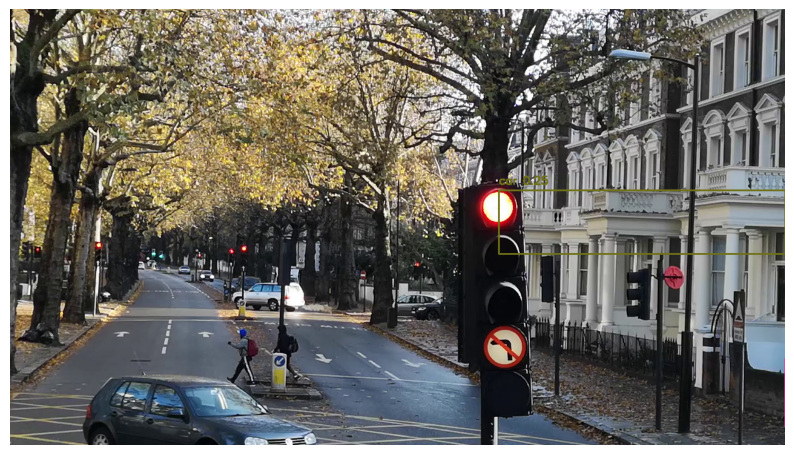

In [8]:
# Single-frame debug (optional)
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

tensor = preprocess_frame(frame)
with torch.no_grad():
    output = model(tensor)[0]

boxes = output['boxes'].cpu()
scores = output['scores'].cpu()
labels = output['labels'].cpu()

# Filter low scores
keep = scores >= 0.25
boxes = boxes[keep]
scores = scores[keep]
labels = labels[keep]

boxes = rescale_boxes(boxes.clone(), (frame.shape[0], frame.shape[1])).int()

# Visualize
for box, score, label in zip(boxes, scores, labels):
    x1, y1, x2, y2 = box.tolist()
    name = idx_to_name.get(label.item(), "Unknown")
    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
    cv2.putText(frame, f"{name} {score:.2f}", (x1, max(y1 - 10, 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Show with matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Step 7: Validation Set Evaluation Code

In [12]:
import os
import json
import torch
import torchvision
import numpy as np
from PIL import Image
from collections import defaultdict
from torchvision import transforms
from pycocotools.coco import COCO
from torchvision.ops import box_iou
from tqdm import tqdm
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import ssd300_vgg16

model = ssd300_vgg16(weights=None)
model.head.classification_head = SSDClassificationHead(
    in_channels=[512, 1024, 512, 256, 256, 256],
    num_anchors=[4, 6, 6, 6, 4, 4],
    num_classes=9  # 8 traffic + 1 background
)
model.load_state_dict(torch.load("C:/Users/admin/Downloads/Code/ObjectDetection/ssdOutput/ssd_model.pth"))
model.to(device)
model.eval()

# ==== 2. Load COCO val annotations ====
ann_path = "C:/Users/admin/Downloads/Code/ObjectDetection/coco_subset/annotations/instances_val2017.json"
img_dir = "C:/Users/admin/Downloads/Code/ObjectDetection/coco_subset/val2017"
coco = COCO(ann_path)
cat_id_to_name = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}
cat_name_to_id = {v: k for k, v in cat_id_to_name.items()}
cat_ids = sorted(cat_id_to_name.keys())
cat_names = [cat_id_to_name[cid] for cid in cat_ids]

# ==== 3. Evaluation storage ====
TP = defaultdict(int)
FP = defaultdict(int)
FN = defaultdict(int)

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# ==== 4. Inference loop ====
for img_id in tqdm(coco.getImgIds()):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image = Image.open(img_path).convert("RGB")
    tensor_img = transform(image).to(device).unsqueeze(0)

    with torch.no_grad():
        outputs = model(tensor_img)[0]

    pred_boxes = outputs['boxes'].cpu()
    pred_labels = outputs['labels'].cpu()
    pred_scores = outputs['scores'].cpu()

    gt_ann = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
    gt_boxes = torch.tensor([ann['bbox'] for ann in gt_ann], dtype=torch.float32)
    gt_boxes[:, 2:] += gt_boxes[:, :2]  # convert [x, y, w, h] -> [x1, y1, x2, y2]
    gt_labels = torch.tensor([ann['category_id'] for ann in gt_ann])

    for cat_id in cat_ids:
        pred_mask = (pred_labels == cat_id) & (pred_scores >= 0.25)  # Apply threshold
        gt_mask = gt_labels == cat_id

        preds = pred_boxes[pred_mask]
        gts = gt_boxes[gt_mask]

        matched_gt = set()

        for pb in preds:
            if len(gts) == 0:
                FP[cat_id] += 1
                continue
            ious = box_iou(pb.unsqueeze(0), gts)[0]
            max_iou, idx = ious.max(0)
            if max_iou > 0.5 and idx.item() not in matched_gt:
                TP[cat_id] += 1
                matched_gt.add(idx.item())
            else:
                FP[cat_id] += 1

        FN[cat_id] += len(gts) - len(matched_gt)

# ==== 5. Compute Precision / Recall / F1 ====
results = []
for cid in cat_ids:
    tp = TP[cid]
    fp = FP[cid]
    fn = FN[cid]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    results.append((cat_id_to_name[cid], precision, recall, f1))

# ==== 6. Display Results ====
import pandas as pd
df = pd.DataFrame(results, columns=["Class", "Precision", "Recall", "F1 Score"])
df.sort_values("F1 Score", ascending=False, inplace=True)

from IPython.display import display
display(df)

# Optional: save to CSV
df.to_csv("C:/Users/admin/Downloads/Code/ObjectDetection/ssdOutput/ssd_f1_scores.csv", index=False)


C:\Users\admin\AppData\Local\Temp\ipykernel_22436\362936410.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Users/admin/Downloads/C

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


100%|██████████| 1000/1000 [00:20<00:00, 48.77it/s]


,Class,Precision,Recall,F1 Score
0,person,0.0,0.0,0.0
1,bicycle,0.0,0.0,0.0
2,car,0.0,0.0,0.0
3,motorcycle,0.0,0.0,0.0
4,bus,0.0,0.0,0.0
5,truck,0.0,0.0,0.0
6,traffic light,0.0,0.0,0.0
7,stop sign,0.0,0.0,0.0


Step 8: Image Detection + Visualization Output Script

In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSDClassificationHead

# === Paths ===
model_path = "C:/Users/admin/Downloads/Code/ObjectDetection/ssdOutput/ssd_model.pth"
image_dir = "C:/Users/admin/Downloads/Code/ObjectDetection/coco_subset/val2017"
output_dir = "C:/Users/admin/Downloads/Code/ObjectDetection/ssdOutput/images_detected"
os.makedirs(output_dir, exist_ok=True)

# === Class names (8 traffic categories + background) ===
class_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic light', 'stop sign']

# === Load model with same structure as training ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ssd300_vgg16(weights=None)
model.head.classification_head = SSDClassificationHead(
    in_channels=[512, 1024, 512, 256, 256, 256],
    num_anchors=[4, 6, 6, 6, 4, 4],
    num_classes=len(class_names)
)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# === Transform input ===
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# === Run detection and draw boxes ===
for file in tqdm(os.listdir(image_dir)):
    if not file.lower().endswith(".jpg"):
        continue

    img_path = os.path.join(image_dir, file)
    image = Image.open(img_path).convert("RGB")
    tensor_img = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(tensor_img)[0]

    boxes = outputs['boxes'].cpu()
    labels = outputs['labels'].cpu()
    scores = outputs['scores'].cpu()

    # Convert image to OpenCV format
    img_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    for box, label, score in zip(boxes, labels, scores):
        if score < 0.25:  # skip low confidence
            continue

        x1, y1, x2, y2 = box.int().tolist()
        label_name = class_names[label]
        cv2.rectangle(img_cv2, (x1, y1), (x2, y2), (0, 165, 255), 2)
        cv2.putText(img_cv2, f"{label_name} {score:.2f}", (x1, y1 - 6),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 165, 255), 1)

    # Save image
    out_path = os.path.join(output_dir, file)
    cv2.imwrite(out_path, img_cv2)

print(f" SSD detection done! Images saved to: {output_dir}")
